<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [2]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 6.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


#**Imports**

In [3]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [4]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs
from scipy.optimize import minimize_scalar

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

In [6]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 500 (delta 63), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (500/500), 60.07 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [7]:
cd INSIST/data

/content/INSIST/data


# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **M 31 Test**

In [17]:
df_M31 = Table.read('M31_crossmatch.fits').to_pandas()
df_M31 = df_M31.rename(columns = {'raStack':'ra','decStack':'dec'})

## **Query**

In [ ]:
try:
  df = casjobs('M 67', cols = {'raStack':'ra','decStack':'dec'}).df
except:
  df = pd.read_csv('M67_PS1.csv')
  df =  df.rename(columns = {'raStack':'ra','decStack':'dec'})

In [ ]:
df_star = df[df['ps_score']>0.5].copy()

In [ ]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score
2,121971328494717854,132.849460,11.647811,14.869100,0.000533,14.360300,0.000274,14.238800,0.000320,14.228000,0.000519,14.180500,0.000877,0.997500
3,121981327802535449,132.780255,11.654201,22.408501,0.070046,21.075701,0.020825,19.894899,0.010747,19.387800,0.012878,19.222099,0.028750,0.967161
7,121981328054472261,132.805456,11.651512,20.532900,0.016547,20.011999,0.012918,19.655001,0.009876,19.598499,0.015401,19.531300,0.032895,0.973104
8,121981328218108430,132.821806,11.656615,21.308001,0.035670,20.095501,0.021422,18.960800,0.006396,18.470501,0.006572,18.143700,0.010728,0.987833
10,121981328277113751,132.827729,11.652668,21.941999,0.059630,20.682800,0.015879,19.333900,0.007499,18.809700,0.007518,18.456301,0.013550,0.969271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.265200,0.000371,13.934200,0.000273,13.864500,0.000378,13.834500,0.000453,13.799800,0.000760,0.998333
1826,122361328754558683,132.875457,11.973499,14.207000,0.000346,13.959600,0.000281,13.872400,0.000384,13.830000,0.000452,13.809400,0.000760,0.998333
1827,122361328818090634,132.881819,11.966787,16.971201,0.001754,16.576300,0.001196,16.217600,0.002029,16.417000,0.002133,16.384300,0.003584,0.997500
1828,122371328134963003,132.813494,11.977090,14.216200,0.000410,13.841900,0.000236,13.694600,0.000315,13.673500,0.000408,13.638000,0.000744,0.994167


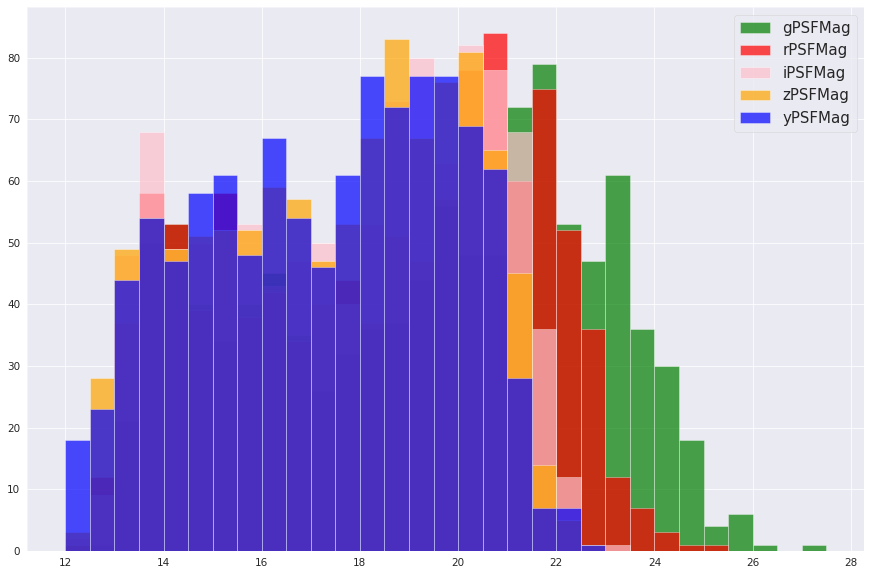

In [ ]:
bin_min = 12
bin_max = 28
step  = 0.5
bins = np.arange(bin_min,bin_max, step)

plt.hist(df_star['gPSFMag'],bins=bins,alpha=0.7,color = 'green')
plt.hist(df_star['rPSFMag'],bins=bins,alpha=0.7,color = 'red')
plt.hist(df_star['iPSFMag'],bins=bins,alpha=0.7,color = 'pink')
plt.hist(df_star['zPSFMag'],bins=bins,alpha=0.7,color = 'orange')
plt.hist(df_star['yPSFMag'],bins=bins,alpha=0.7,color = 'blue');
plt.legend(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag',])

# **Synthetic Spectra**

## **Model**

In [8]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [9]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  6006k      0  0:00:14  0:00:14 --:--:-- 11.3M


In [10]:
!tar -xzf models

In [11]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [15]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

model_dir = 'models_kurucz'

filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0]*u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [16]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


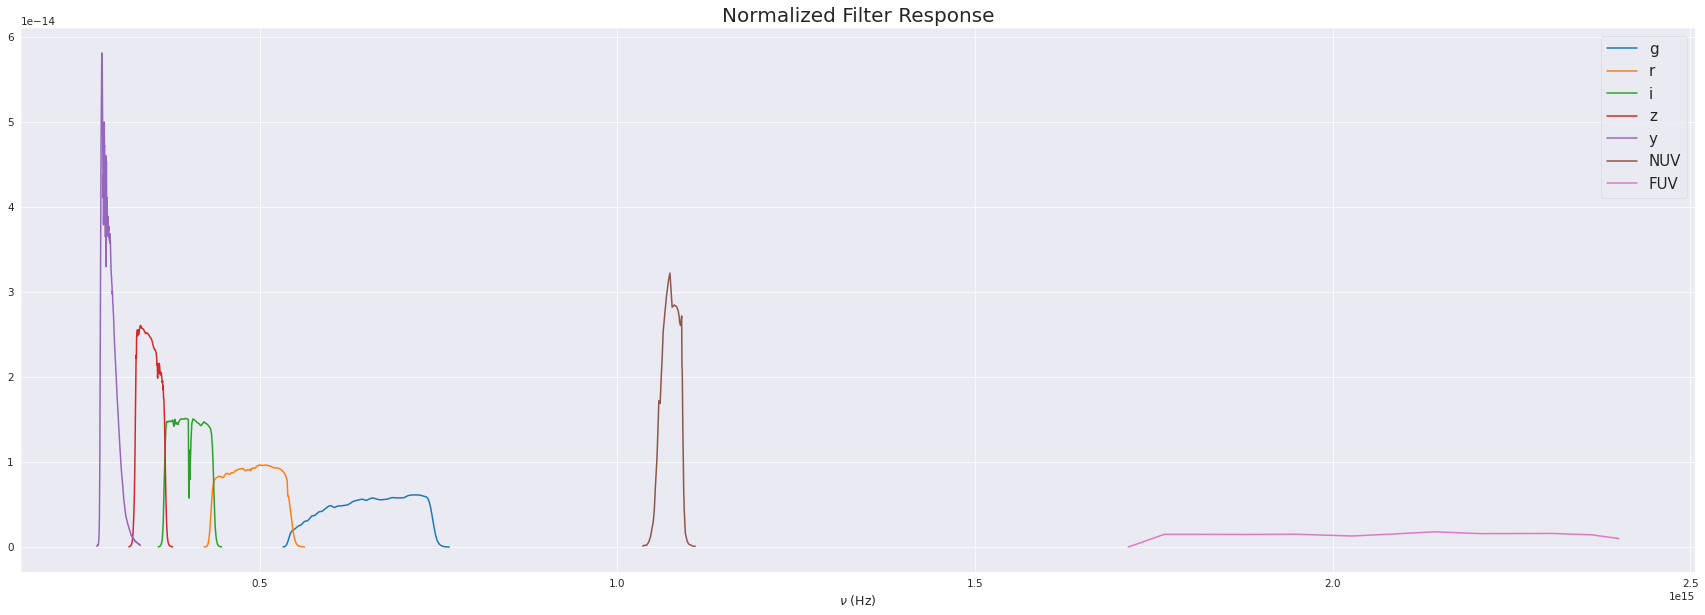

In [18]:
plt.figure(figsize = (30,10))
for filter in filter_list:
  plt.plot(filter.nu,filter.response)

plt.xlabel(r'$\nu$ (Hz)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])

## **Formatting the data**

In [37]:
df_M31

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,b'FUVCaF2 ',10.9214,41.411098,22.725000,20.323999,0.118,"b'1, 2 '",3,157690109219783649,10.921927,41.410857,24.503000,0.898741,22.616501,0.154439,20.747101,0.033730,20.456499,0.058414,19.838301,0.072363,0.509452,1.667120
1,b'FUVCaF2 ',10.9371,41.406700,22.476999,20.076000,0.104,"b'1, 2 '",3,157680109372618605,10.937447,41.406847,21.477600,0.057900,21.733500,0.077796,21.298500,0.056851,20.992399,0.082071,22.087700,0.542719,0.114917,1.073495
2,b'FUVCaF2 ',10.8697,41.449402,23.221001,20.820000,0.146,"b'1, 2 '",3,157730108691729610,10.869178,41.449182,25.541800,1.851880,23.641300,0.440230,21.589600,0.066110,20.281000,0.049900,20.015600,0.076861,0.399167,1.616849
3,b'FUVCaF2 ',10.8234,41.446098,23.188000,20.787001,0.140,"b'1, 2 '",0,157730108247884670,10.824714,41.444954,25.177401,1.472050,22.412600,0.135438,21.101000,0.041291,20.420300,0.071485,19.761801,0.067128,0.052833,5.434593
4,b'FUVCaF2 ',11.0038,41.372299,23.337000,20.936001,0.155,"b'1, 2 '",3,157640110044267229,11.004415,41.371906,24.202400,0.513870,22.555500,0.153106,22.459101,0.152679,21.070499,0.112956,20.164400,0.084372,0.654958,2.181500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21698,b'NUVN2 ',11.0708,41.366199,21.108999,19.608999,0.246,b'7 ',0,157640110703900427,11.070470,41.366576,21.585600,0.046389,21.066299,0.044974,20.903601,0.032214,20.759100,0.070550,20.596800,0.110662,0.008333,1.621739
21699,b'NUVN2 ',11.0346,41.335098,20.375999,18.875999,0.166,b'7 ',3,157600110347844126,11.034920,41.336303,22.577101,0.124772,21.076000,0.032083,20.244499,0.017173,19.897499,0.032268,19.356701,0.053241,0.523750,4.422072
21700,b'NUVN2 ',11.0573,41.263199,20.670000,19.170000,0.190,b'7 ',3,157510110583196360,11.058330,41.263118,19.408001,0.008130,19.376699,0.010138,19.431101,0.008153,19.435499,0.019924,19.267700,0.035264,0.866440,2.804629
21701,b'NUVN2 ',10.9757,41.238400,21.011000,19.511000,0.224,b'7 ',3,157480109756396585,10.975620,41.238344,20.956499,0.029092,20.614799,0.021377,20.267099,0.018775,20.139000,0.044767,20.216801,0.085587,0.451369,0.294241


In [66]:
df_star = df_M31[:1].copy()

In [41]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000
  df_star[f'{i}PSFFlux_err'] = 1.09*df_star[f'{i}PSFMagErr']/df_star[f'{i}PSFMag']*1000

In [42]:
df_star['g_flag'] = 1
df_star['i_flag'] = 1
df_star['r_flag'] = 1
df_star['z_flag'] = 1
df_star['y_flag'] = 1

In [67]:
df_star = df_star.drop_duplicates('objid')
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,b'FUVCaF2 ',10.9214,41.411098,22.725,20.323999,0.118,"b'1, 2 '",3,157690109219783649,10.921927,41.410857,24.503,0.898741,22.616501,0.154439,20.747101,0.03373,20.456499,0.058414,19.838301,0.072363,0.509452,1.66712


In [68]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ]

In [69]:
df_star[filters]

,ABmag,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
0,22.725,24.503,22.616501,20.747101,20.456499,19.838301


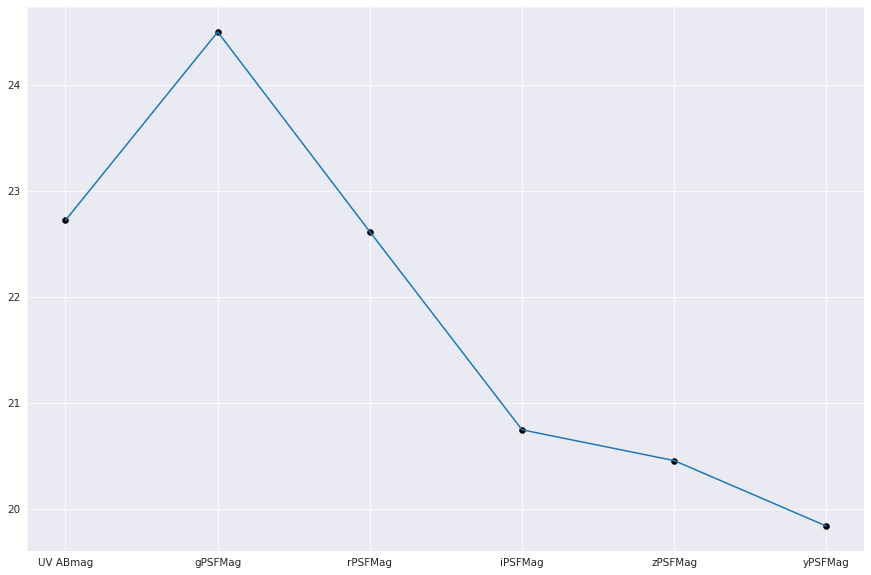

In [75]:
for i,flux in df_star[filters].iterrows():
  plt.scatter(['UV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux,marker = 'o', color = 'black')
  plt.plot(['UV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux)
  break

In [30]:
df_out = df_star[['objid', 'ra', 'dec', 'g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

In [31]:
df_out 

,objid,ra,dec,g_flag,i_flag,r_flag,z_flag,y_flag,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
0,157690109219783649,10.921927,41.410857,1,1,1,1,1,0.000574,39.979908,0.003262,7.443172,0.018247,1.772089,0.023847,3.11252,0.042141,3.975929


In [ ]:
df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

## **SED Fitting**

### **SED Fitter**

In [ ]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.000 Mpc

 ------------------------------------------------------------
  => Output parameters
 ----

Extracting fitting parameters from SED Fitter output

In [ ]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')
nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)

UV = []
chi2 = []
for info in fin:
  model_name = info.model_name[0]
  chi2.append(info.chi2[0])
  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  UV.append(NUV + FUV)
UV = np.array(UV)

In [ ]:
UV

array([[5.48188220e-07, 9.76604113e-10, 2.08393337e-13, 5.83871870e-16],
       [2.08067871e+03, 2.08839186e+00, 3.31527956e+03, 4.64927354e+00],
       [5.48188220e-07, 9.76604113e-10, 2.08393337e-13, 5.83871870e-16],
       ...,
       [2.08067871e+03, 2.08839186e+00, 3.31527956e+03, 4.64927354e+00],
       [2.83759140e-07, 5.16000508e-10, 6.53501534e-14, 1.82230628e-16],
       [1.05139237e+03, 1.06036418e+00, 1.48923002e+03, 2.10703789e+00]])

In [ ]:
df_star['NUV_ABmag'] = -2.5*np.log10(UV[:,0]/3631e3)
df_star['FUV_ABmag'] = -2.5*np.log10(UV[:,2]/3631e3)

In [ ]:
df_star[['ABmag','FUV_ABmag']]

,ABmag,FUV_ABmag
0,22.725000,48.102856
1,22.476999,7.598765
2,23.221001,48.102856
3,23.188000,48.102856
4,23.337000,48.102856
...,...,...
995,22.677999,48.102856
996,22.422001,48.727240
997,22.784000,7.598765
998,21.740000,49.361949


Text(0.5, 1.0, 'SED Fitter')

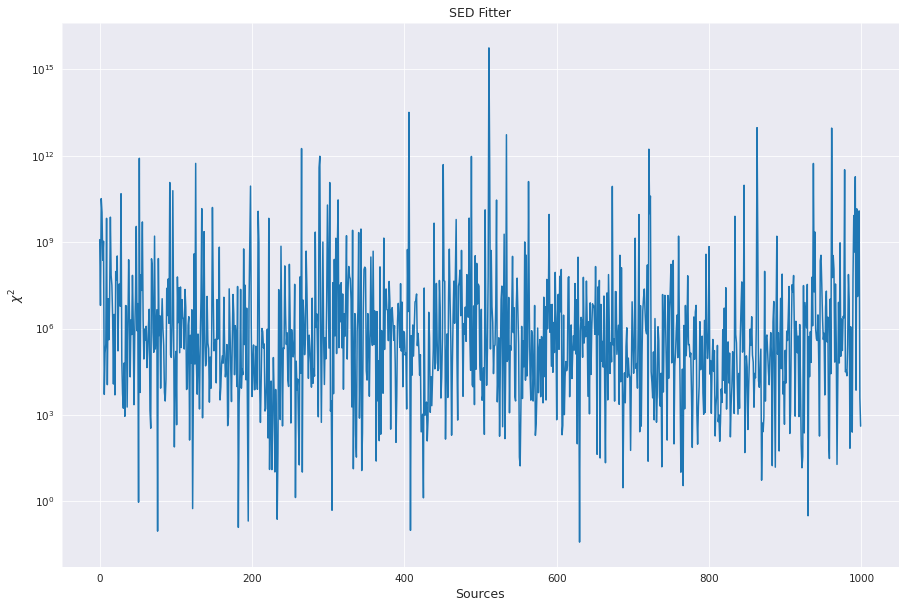

In [ ]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

In [ ]:
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag,NUV_ABmag,FUV_ABmag
0,b'FUVCaF2 ',10.9214,41.411098,22.725000,20.323999,0.118,"b'1, 2 '",3,157690109219783649,10.921927,41.410857,24.503000,0.898741,22.616501,0.154439,20.747101,0.033730,20.456499,0.058414,19.838301,0.072363,0.509452,1.667120,5.738867e-07,0.039980,0.000003,0.007443,0.000018,0.001772,0.000024,0.003113,4.214111e-05,0.003976,1,1,1,1,1,-32.052741,-48.102856
1,b'FUVCaF2 ',10.9371,41.406700,22.476999,20.076000,0.104,"b'1, 2 '",3,157680109372618605,10.937447,41.406847,21.477600,0.057900,21.733500,0.077796,21.298500,0.056851,20.992399,0.082071,22.087700,0.542719,0.114917,1.073495,9.310783e-06,0.002938,0.000007,0.003902,0.000011,0.002909,0.000015,0.004261,5.308188e-06,0.026782,1,1,1,1,1,-8.104553,-7.598765
2,b'FUVCaF2 ',10.8697,41.449402,23.221001,20.820000,0.146,"b'1, 2 '",3,157730108691729610,10.869178,41.449182,25.541800,1.851880,23.641300,0.440230,21.589600,0.066110,20.281000,0.049900,20.015600,0.076861,0.399167,1.616849,2.204481e-07,0.079029,0.000001,0.020297,0.000008,0.003338,0.000028,0.002682,3.579202e-05,0.004186,1,1,1,1,1,-32.052741,-48.102856
3,b'FUVCaF2 ',10.8234,41.446098,23.188000,20.787001,0.140,"b'1, 2 '",0,157730108247884670,10.824714,41.444954,25.177401,1.472050,22.412600,0.135438,21.101000,0.041291,20.420300,0.071485,19.761801,0.067128,0.052833,5.434593,3.083657e-07,0.063729,0.000004,0.006587,0.000013,0.002133,0.000025,0.003816,4.521744e-05,0.003703,1,1,1,1,1,-32.052741,-48.102856
4,b'FUVCaF2 ',11.0038,41.372299,23.337000,20.936001,0.155,"b'1, 2 '",3,157640110044267229,11.004415,41.371906,24.202400,0.513870,22.555500,0.153106,22.459101,0.152679,21.070499,0.112956,20.164400,0.084372,0.654958,2.181500,7.569482e-07,0.023143,0.000003,0.007399,0.000004,0.007410,0.000014,0.005843,3.120802e-05,0.004561,1,1,1,1,1,-32.052741,-48.102856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,b'FUVCaF2 ',10.8185,41.604801,22.677999,20.277000,0.122,"b'2, 5 '",3,157920108172546270,10.817116,41.604681,23.357700,0.222642,22.926399,0.165202,22.332399,0.103733,21.288700,0.154324,20.054300,0.075952,0.556690,3.750251,1.647958e-06,0.010390,0.000002,0.007854,0.000004,0.005063,0.000011,0.007902,3.453871e-05,0.004128,1,1,1,1,1,-32.052741,-48.102856
996,b'FUVCaF2 ',10.7603,41.648701,22.422001,20.021000,0.116,"b'2, 5 '",3,157970107623978906,10.762250,41.648522,24.198299,0.476317,23.130800,0.211941,21.496300,0.042480,20.573999,0.052797,21.230101,0.193864,0.459104,5.286717,7.598126e-07,0.021455,0.000002,0.009987,0.000009,0.002154,0.000021,0.002797,1.169462e-05,0.009953,1,1,1,1,1,-32.403116,-48.727240
997,b'FUVCaF2 ',10.7655,41.679798,22.784000,20.382999,0.130,"b'2, 5 '",3,158010107654546371,10.765439,41.679820,21.763800,0.039520,21.933599,0.076260,21.996599,0.068056,23.371201,0.581476,24.357800,3.210520,0.220935,0.182104,7.153299e-06,0.001979,0.000006,0.003790,0.000006,0.003372,0.000002,0.027119,6.560039e-07,0.143669,1,1,1,1,1,-8.104553,-7.598765
998,b'FUVCaF2 ',10.7910,41.627899,21.740000,19.339001,0.083,"b'2, 5 '",3,157950107919523214,10.791973,41.627162,21.233101,0.028844,19.673599,0.010297,18.953899,0.005034,18.395300,0.006828,18.177299,0.012634,0.929042,3.729338,1.166235e-05,0.001481,0.000049,0.000570,0.000095,0.000289,0.000159,0.000405,1.945837e-04,0.000758,1,1,1,1,1,-32.767691,-49.361949


# **SED Fitting Routine**

In [44]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return chi@chi

In [45]:
# Convolved Filters
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]

chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_out.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)

    Md = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    chi2 = chi2_func(Md,flux,model_flux,flux_err)

    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [53]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [54]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [56]:
df_chi_min

,objid,model_name,Md,chi2
3,1.576901e+17,kt03500g+0.0z-0.5,0.040306,0.000002


In [55]:
len(df_chi_min.model_name.unique())

1

In [63]:
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)
flux = []

for model_name in df_chi_min['model_name']:
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append(FUV + NUV + g + r + i +z + y)

flux = np.array(flux)

In [64]:
tab_star = Table.from_pandas(df_star)
tab_star['model_flux'] = flux
tab_star['model_mag'] =  -2.5*np.log10(flux/3631000)

In [65]:
tab_star

Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag,NUV_ABmag,FUV_ABmag,model_flux [14],model_mag [14]
bytes11,float32,float32,float32,float32,float32,bytes10,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64
FUVCaF2,10.9214,41.4111,22.725,20.324,0.118,"1, 2",3,157690109219783649,10.92192707,41.41085716,24.5030002593994,0.898741006851196,22.6165008544922,0.154439002275467,20.7471008300781,0.0337300002574921,20.4564990997314,0.0584140010178089,19.8383007049561,0.0723629966378212,0.509452402591705,1.6671202386556518,0.0005738866804391734,39.97990805603557,0.003261564016790127,7.443172291032051,0.018246766599578117,1.7720885718820691,0.023846607800307697,3.112519928214292,0.04214110962724249,3.9759285590181626,1,1,1,1,1,30.62230734574891,52.59336387076969,3.3318136308058835e-15 .. 0.0021143414230130097,52.59336387076969 .. 23.087127826445535


In [ ]:
for i,flux in df_star[filters].iterrows():
  plt.scatter(['UV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux,marker = 'o', color = 'black')
  plt.plot(['UV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux)
  break